In [1]:
# BiLSTM-based Intrusion Detection on TON IoT Dataset (Rewritten)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split

# Load Dataset
df = pd.read_csv('../dataset/final_df.csv', low_memory=False)
print("Original DataFrame Head:\n", df.head())
print("\nOriginal Class Distribution:\n", df['type'].value_counts())
print("\nOriginal Label Distribution:\n", df['label'].value_counts())
print("\nOriginal Data Types:\n", df.dtypes)
print("\nOriginal Data Shapes:\n", df.shape)

# --- Data Preprocessing ---
# Clean and impute
df['src_bytes'] = pd.to_numeric(df['src_bytes'], errors='coerce').fillna(0)
df.drop_duplicates(inplace=True)

df.fillna(df.mean(numeric_only=True), inplace=True)
print(f"Shape after dropping duplicates: {df.shape}")

for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype == 'object':
            df[col].fillna('Missing', inplace=True) # Or df[col].mode()[0]
        else:
            df[col].fillna(df[col].mean(), inplace=True)

print(f"Shape after handling NaNs: {df.shape}")

# Identify targets
TARGET_LABEL = 'label'
TARGET_TYPE = 'type'

# Encode categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if TARGET_TYPE in categorical_cols:
    categorical_cols.remove(TARGET_TYPE)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded column: {col}")

# Normalize numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if TARGET_LABEL in numerical_cols:
    numerical_cols.remove(TARGET_LABEL)

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")


Original DataFrame Head:
            ts         src_ip  src_port        dst_ip  dst_port proto service  \
0  1556499101  192.168.1.193     60396  192.168.1.33      8080   tcp       -   
1  1556494424  192.168.1.193     59273  192.168.1.33      8080   tcp       -   
2  1556487945  192.168.1.193     57717  192.168.1.33      8080   tcp       -   
3  1556508616  192.168.1.193     62682  192.168.1.33        80   tcp       -   
4  1556511697  192.168.1.193     63419  192.168.1.33      8080   tcp       -   

   duration src_bytes  dst_bytes  ... http_response_body_len  \
0  0.000180         0          0  ...                      0   
1  0.000111         0          0  ...                      0   
2  0.000148         0          0  ...                      0   
3  0.000127         0          0  ...                      0   
4  0.000122         0          0  ...                      0   

   http_status_code  http_user_agent  http_orig_mime_types  \
0                 0                -          

In [2]:
binary_y = df[TARGET_LABEL].values
type_encoder = LabelEncoder()
y_multiclass_encoded = type_encoder.fit_transform(df[TARGET_TYPE])
# Convert to one-hot encoding for Keras if using categorical_crossentropy
y_multiclass_onehot = to_categorical(y_multiclass_encoded)

y_multiclass_labels = np.argmax(y_multiclass_onehot, axis=1)

# Drop targets from features
X = df.drop(columns=[TARGET_LABEL, TARGET_TYPE]).values
print("Feature shape (flat):", X.shape)
print("Binary target shape:", binary_y.shape)
print("Multi-class target shape:", y_multiclass_labels.shape)

# print the class distribution of binary_y and y_multiclass_labels
print("Binary target class distribution:")
print(Counter(binary_y))
print("Multi-class target class distribution:")
print(Counter(y_multiclass_labels))

Feature shape (flat): (441043, 44)
Binary target shape: (441043,)
Multi-class target shape: (441043,)
Binary target class distribution:
Counter({np.int64(0): 300000, np.int64(1): 141043})
Multi-class target class distribution:
Counter({np.int64(5): 300000, np.int64(0): 20000, np.int64(1): 20000, np.int64(2): 20000, np.int64(3): 20000, np.int64(6): 20000, np.int64(7): 20000, np.int64(8): 20000, np.int64(4): 1043})


In [3]:
# 1. Split BEFORE SMOTE (to avoid leakage)
# ----------------------------------------
X_train, X_test, \
y_train_binary, y_test_binary, \
y_train_multi, y_test_multi = train_test_split(
    X,
    binary_y,
    y_multiclass_labels,
    test_size=0.2,
    random_state=42,
    stratify=binary_y  # stratify on binary for this example
)

# Reset indices
X_train = pd.DataFrame(X_train).reset_index(drop=True).values
X_test = pd.DataFrame(X_test).reset_index(drop=True).values

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train_binary shape: {y_train_binary.shape}")
print(f"y_train_multiclass labels shape: {y_train_multi.shape}")
print(f"X_test  shape: {X_test.shape}")
print(f"y_test_binary shape: {y_test_binary.shape}")
print(f"y_test_multiclass labels shape: {y_test_multi.shape}")

# print the class distribution of binary_y and y_multiclass
# print the class distribution of binary_y and y_multiclass
print("Binary target class distribution:")
print(Counter(y_train_binary))
print("Multi-class target class distribution:")
print(Counter(y_train_multi))
print("Binary target class distribution:")
print(Counter(y_test_binary))
print("Multi-class target class distribution:")
print(Counter(y_test_multi))

# scaling the training data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Scaling complete.")


X_train shape: (352834, 44)
y_train_binary shape: (352834,)
y_train_multiclass labels shape: (352834,)
X_test  shape: (88209, 44)
y_test_binary shape: (88209,)
y_test_multiclass labels shape: (88209,)
Binary target class distribution:
Counter({np.int64(0): 240000, np.int64(1): 112834})
Multi-class target class distribution:
Counter({np.int64(5): 240000, np.int64(3): 16075, np.int64(0): 16049, np.int64(7): 16043, np.int64(1): 15999, np.int64(6): 15960, np.int64(2): 15940, np.int64(8): 15935, np.int64(4): 833})
Binary target class distribution:
Counter({np.int64(0): 60000, np.int64(1): 28209})
Multi-class target class distribution:
Counter({np.int64(5): 60000, np.int64(8): 4065, np.int64(2): 4060, np.int64(6): 4040, np.int64(1): 4001, np.int64(7): 3957, np.int64(0): 3951, np.int64(3): 3925, np.int64(4): 210})
Scaling complete.


In [4]:
# --- Create Sequences ---
def create_sequences(
    X,
    y,
    window_size: int = 10,
    debug: bool = False,
    trace_limit: int = 5
):
    # Convert to numpy if not already
    X = np.asarray(X)
    y = np.asarray(y)

    # Input validation
    if len(X) != len(y):
        raise ValueError("X and y must have the same number of samples")
    if len(X.shape) != 2:
        raise ValueError("X must be a 2D array: (samples, features)")
    if len(y.shape) > 2:
        raise ValueError("y must be a 1D or 2D array")

    X_seq, y_seq = [], []
    total = len(X) - window_size + 1
    if debug:
        print(f"Total samples: {len(X)} | Generating {total} sequences (window_size={window_size})")

    for i in range(total):
        window = X[i : i + window_size]
        label = y[i + window_size - 1]
        X_seq.append(window)
        y_seq.append(label)

        if debug and i < trace_limit:
            print(f"\n--- Seq {i+1}/{total} ---")
            print(f"  X indices: {i} to {i+window_size-1}")
            print(f"  y index:   {i+window_size-1} → label={label}")
            print(f"  window.shape: {window.shape}")

    if debug:
        print(f"\nTotal sequences generated: {len(X_seq)}")

    return np.array(X_seq), np.array(y_seq)


TIMESTEPS = 20
X_train_seq, y_train_seq = create_sequences(X_train, y_train_binary, window_size=TIMESTEPS, debug=True)
X_test_seq, y_test_seq = create_sequences(X_test, y_test_binary, window_size=TIMESTEPS, debug=True)


print("Train sequence shape:", X_train_seq.shape)  # (samples, timesteps, features)
print("Test sequence shape:", X_test_seq.shape)
print("Binary target distribution:", Counter(y_train_binary))

# counters
print("Class distribution in y_train_seq:", Counter(y_train_seq))
print("Class distribution in y_test_seq:", Counter(y_test_seq))

# multiclass sequence generation.
# X_train_seq_multi, y_train_seq_multi = create_sequences(X_train, y_train_multi, debug=True)
# X_test_seq_multi, y_test_seq_multi = create_sequences(X_test, y_test_multi, debug=True)


Total samples: 352834 | Generating 352815 sequences (window_size=20)

--- Seq 1/352815 ---
  X indices: 0 to 19
  y index:   19 → label=0
  window.shape: (20, 44)

--- Seq 2/352815 ---
  X indices: 1 to 20
  y index:   20 → label=1
  window.shape: (20, 44)

--- Seq 3/352815 ---
  X indices: 2 to 21
  y index:   21 → label=1
  window.shape: (20, 44)

--- Seq 4/352815 ---
  X indices: 3 to 22
  y index:   22 → label=1
  window.shape: (20, 44)

--- Seq 5/352815 ---
  X indices: 4 to 23
  y index:   23 → label=1
  window.shape: (20, 44)

Total sequences generated: 352815
Total samples: 88209 | Generating 88190 sequences (window_size=20)

--- Seq 1/88190 ---
  X indices: 0 to 19
  y index:   19 → label=0
  window.shape: (20, 44)

--- Seq 2/88190 ---
  X indices: 1 to 20
  y index:   20 → label=0
  window.shape: (20, 44)

--- Seq 3/88190 ---
  X indices: 2 to 21
  y index:   21 → label=0
  window.shape: (20, 44)

--- Seq 4/88190 ---
  X indices: 3 to 22
  y index:   22 → label=0
  window.sha

In [5]:
from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTEENN

n_windows, Timestamps, Features = X_train_seq.shape
print("n_windows:", n_windows, "Timestamps:", Timestamps, "Features:", Features)

# 2. Flatten windows to 2D
X_flat = X_train_seq.reshape(n_windows, Timestamps * Features)

# 3. SMOTE on the flattened windows
sm = SMOTE(random_state=42)
X_train_seq_bal, y_train_seq_bal = sm.fit_resample(X_flat, y_train_seq)

# 4. Reshape back to 3D sequenc es
n_balanced = X_train_seq_bal.shape[0]
X_train_seq_bal = X_train_seq_bal.reshape(n_balanced, Timestamps, Features)

print("SMOTE applied on sequences")
print(f"X_train_seq_bal shape: {X_train_seq_bal.shape}")
print(f"y_train_seq_bal shape: {y_train_seq_bal.shape}")
#counters
print("Class distribution in y_train_seq_bal:", Counter(y_train_seq_bal))
print("Class distribution in y_train_seq:", Counter(y_train_seq))

# time: 6m 30.6s


n_windows: 352815 Timestamps: 20 Features: 44
SMOTE applied on sequences
X_train_seq_bal shape: (479968, 20, 44)
y_train_seq_bal shape: (479968,)
Class distribution in y_train_seq_bal: Counter({np.int64(0): 239984, np.int64(1): 239984})
Class distribution in y_train_seq: Counter({np.int64(0): 239984, np.int64(1): 112831})


In [6]:
print("Unique labels in y_train_seq_bal:", np.unique(y_train_seq_bal))
print("Unique labels in y_test_seq:", np.unique(y_test_seq))

# Optional: count distribution
print("Train label distribution:", Counter(y_train_seq_bal))
print("Test label distribution:", Counter(y_test_seq))


Unique labels in y_train_seq_bal: [0 1]
Unique labels in y_test_seq: [0 1]
Train label distribution: Counter({np.int64(0): 239984, np.int64(1): 239984})
Test label distribution: Counter({np.int64(0): 59990, np.int64(1): 28200})


In [7]:
from sklearn.utils import shuffle

X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_seq_bal, y_train_seq_bal, random_state=42)
# X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_seq, y_train_seq, random_state=42)

val_fraction = 0.2
n_total = X_train_seq_bal_shuffle.shape[0]
n_val = int(n_total * val_fraction)

X_val_seq = X_train_seq_bal_shuffle[-n_val:]
y_val_seq = y_train_seq_bal_shuffle[-n_val:]
X_train_seq_final = X_train_seq_bal_shuffle[:-n_val]
y_train_seq_final = y_train_seq_bal_shuffle[:-n_val]

print("Final training shapes:")
print(f"X_train_seq_final shape: {X_train_seq_final.shape}")
print(f"y_train_seq_final shape: {y_train_seq_final.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")

print("Final training label distributions:")
print(f"y_train_seq_final distribution: {Counter(y_train_seq_final)}")
print(f"y_val_seq distribution: {Counter(y_val_seq)}")

Final training shapes:
X_train_seq_final shape: (383975, 20, 44)
y_train_seq_final shape: (383975,)
X_val_seq shape: (95993, 20, 44)
y_val_seq shape: (95993,)
Final training label distributions:
y_train_seq_final distribution: Counter({np.int64(1): 192084, np.int64(0): 191891})
y_val_seq distribution: Counter({np.int64(0): 48093, np.int64(1): 47900})


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 20, 256)        │       177,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 20, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,433 (1.32 MB)

 Trainable params: 346,433 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-08-31 22:59:50.855899: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 230s 37ms/step - accuracy: 0.8362 - auc: 0.9465 - loss: 0.8313 - precision: 0.7564 - recall: 0.9922 - val_accuracy: 0.9411 - val_auc: 0.9849 - val_loss: 0.3060 - val_precision: 0.8986 - val_recall: 0.9941 - learning_rate: 1.0000e-04
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 223s 37ms/step - accuracy: 0.9426 - auc: 0.9862 - loss: 0.3453 - precision: 0.9018 - recall: 0.9935 - val_accuracy: 0.9562 - val_auc: 0.9911 - val_loss: 0.1867 - val_precision: 0.9236 - val_recall: 0.9945 - learning_rate: 1.0000e-04
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 224s 37ms/step - accuracy: 0.9571 - auc: 0.9910 - loss: 0.2662 - precision: 0.9261 - recall: 0.9935 - val_accuracy: 0.9702 - val_auc: 0.9928 - val_loss: 0.1422 - val_precision: 0.9490 - val_recall: 0.9938 - learning_rate: 1.0000e-04
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 224s 37ms/step - accuracy: 0.9634 - auc: 0.9922 - loss: 0.2347 - precision: 0.9368 - recall: 0.9938 - val_accuracy: 0.9746 - val_auc: 0.9926 - v

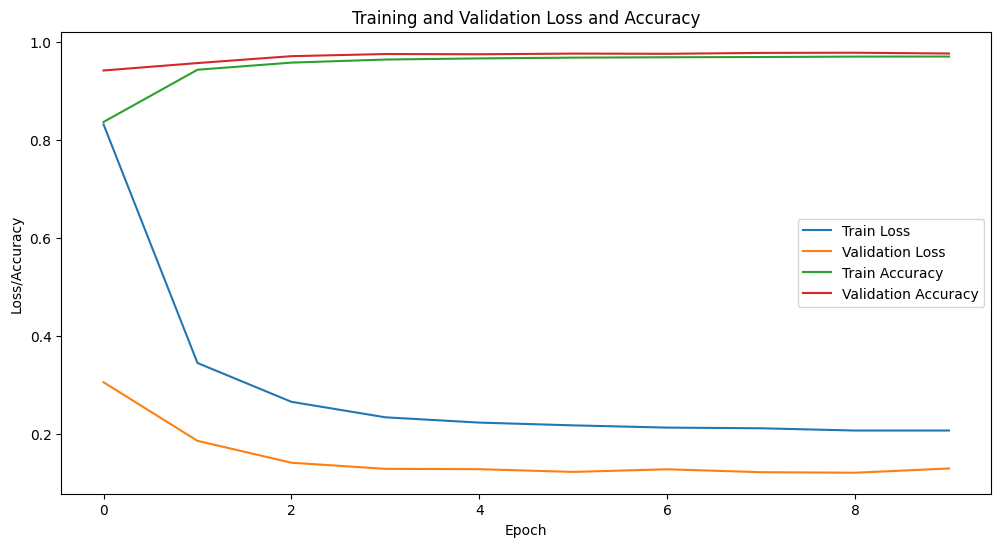

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step


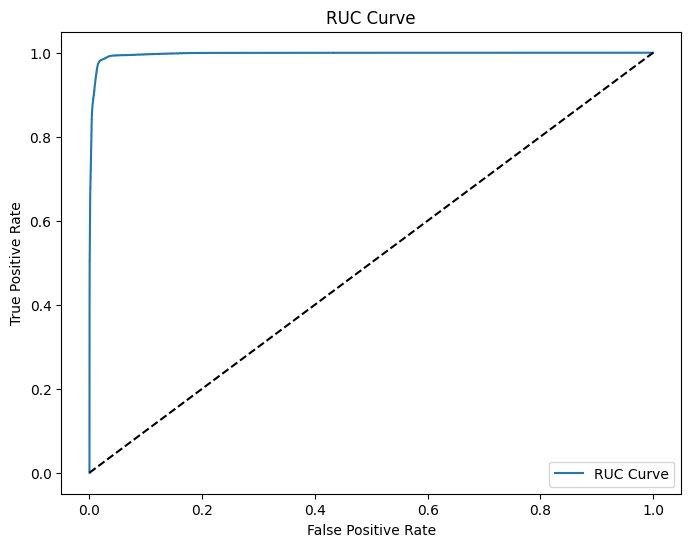

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step


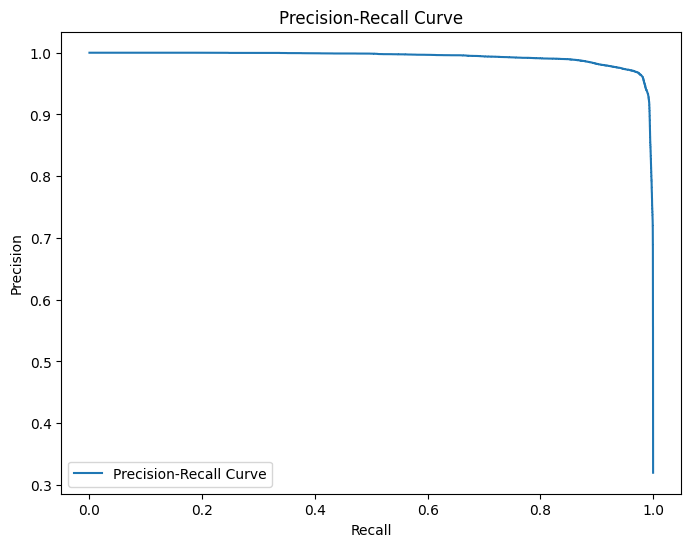

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, AUC
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score, classification_report, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt

# Model definition
model = Sequential([
    Bidirectional(LSTM(
        128, 
        return_sequences=True,  # Only final output
        recurrent_dropout=0.2,
        recurrent_activation='sigmoid',
        activation='tanh'
    ),
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])),
    LayerNormalization(),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    LayerNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])
model.summary()

optimizer = Adam(
    learning_rate=0.0001,  # Very low initial LR
    clipnorm=1.0,  # Gradient clipping to prevent exploding gradients
    weight_decay=1e-4
)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Recall(name='recall'),
        Precision(name='precision')
    ]
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train_seq_bal), y=y_train_seq_bal)
# class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict = {0: 1.0, 1: 10.0}


# Train
history = model.fit(
    X_train_seq_final, y_train_seq_final,
    validation_data=(X_val_seq, y_val_seq),
    # validation_split=0.2,
    epochs=10,
    batch_size=64,
    shuffle=False,  # Important for time series
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

results = model.evaluate(X_test_seq, y_test_seq, verbose=2)

print("Test Loss: {}".format(results[0]))
print("Test Accuracy: {}".format(results[1]))

# Print classification report
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32").flatten()
print(classification_report(y_test_seq, y_pred))

#confusion matrix
cm = confusion_matrix(y_test_seq, y_pred)
print(cm)
# fnr and fpr
tn, fp, fn, tp = cm.ravel()
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)
print("False Negative Rate (FNR):", fnr)
print("False Positive Rate (FPR):", fpr)

# plot validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

# plot RUC curve
fpr, tpr, _ = roc_curve(y_test_seq, model.predict(X_test_seq).ravel())
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='RUC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RUC Curve')
plt.legend()
plt.show()

# plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test_seq, model.predict(X_test_seq).ravel())
plt.figure(figsize=(8, 6))  
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve') 
plt.legend()
plt.show()


In [ ]:
# Hyperparameter Tuning with Bayesian Optimization (BayesSearchCV)
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold

def build_bilstm_model(
    lstm_units=64,
    hidden_layer=32,
    dropout=0.2,
    learning_rate=0.001,
    input_shape=(30, 44)
):
    model = Sequential([
        Bidirectional(LSTM(int(lstm_units*2), return_sequences=True, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2), input_shape=input_shape),
        LayerNormalization(),
        Dropout(dropout),
        Bidirectional(LSTM(int(lstm_units))),
        LayerNormalization(),
        Dropout(dropout),
        Dense(int(hidden_layer), activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

from sklearn.metrics import make_scorer

def constrained_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = accuracy_score(y_true, y_pred)
        # Constraints: FNR ≤ 0.01, FPR ≤ 0.5, Accuracy > 0.90
        if fnr <= 0.01 and fpr <= 0.5 and acc > 0.90:
            print(f"Valid model found: FNR={fnr}, FPR={fpr}, Acc={acc}")
            return acc
        else:
            print(f"Model rejected: FNR={fnr}, FPR={fpr}, Acc={acc}")
            return 0
    else:
        # If confusion matrix is not 2x2, return 0
        return 0

constrained_scorer = make_scorer(constrained_score)
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train_seq_bal), y=y_train_seq_bal)
# class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict = {0: 1.0, 1: 10.0}
# Wrap the model for scikit-learn compatibility
keras_clf = KerasClassifier(
    model=build_bilstm_model,
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])
)

# Define the hyperparameter search space
param_space = {
    'model__lstm_units': Integer(64, 128),
    'model__hidden_layer': Integer(16, 32),
    'model__dropout': Real(0.2, 0.4),
    'model__learning_rate': Real(1e-4, 1e-2, prior='log-uniform'),
    'batch_size': Categorical([64, 128]),
    'epochs': Integer(5, 10)
}

opt = BayesSearchCV(
    estimator=keras_clf,
    search_spaces=param_space,
    n_iter=10,
    scoring=constrained_scorer,
    # cv=2,
    cv=cv_strategy,
    n_jobs=1,
    verbose=2,
    refit=True
)

# Fit the optimizer (this may take a while)
opt.fit(X_train_seq_final, y_train_seq_final, callbacks=[early_stopping, reduce_lr], validation_split=0.2, class_weight=class_weight_dict)

print('Best parameters:', opt.best_params_)
print('Best cross-validation accuracy:', opt.best_score_)

# Evaluate on test set
test_score = opt.score(X_test_seq, y_test_seq)
print('Test set accuracy:', test_score)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 80s 46ms/step - accuracy: 0.7482 - loss: 0.9197 - val_accuracy: 0.8597 - val_loss: 0.4413
Epoch 2/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.8855 - loss: 0.4847 - val_accuracy: 0.9353 - val_loss: 0.2605
Epoch 3/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9223 - loss: 0.3637 - val_accuracy: 0.9461 - val_loss: 0.2122
Epoch 4/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9351 - loss: 0.3127 - val_accuracy: 0.9545 - val_loss: 0.1664
Epoch 5/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9419 - loss: 0.2835 - val_accuracy: 0.9576 - val_loss: 0.1499
Epoch 6/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9473 - loss: 0.2573 - val_accuracy: 0.9609 - val_loss: 0.1360
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step
Valid model found: FNR=0.004810395451989754, FPR=0.07177474829591646, Acc=0.9617241702606413
[CV] END batch_size=128, epochs=6, model__dropout=0.37017444844165126, model

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 77s 46ms/step - accuracy: 0.7476 - loss: 0.9206 - val_accuracy: 0.8317 - val_loss: 0.5133
Epoch 2/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 72s 45ms/step - accuracy: 0.8733 - loss: 0.5170 - val_accuracy: 0.9294 - val_loss: 0.2569
Epoch 3/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 72s 45ms/step - accuracy: 0.9209 - loss: 0.3670 - val_accuracy: 0.9441 - val_loss: 0.2020
Epoch 4/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 72s 45ms/step - accuracy: 0.9355 - loss: 0.3110 - val_accuracy: 0.9531 - val_loss: 0.1727
Epoch 5/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 72s 45ms/step - accuracy: 0.9441 - loss: 0.2712 - val_accuracy: 0.9577 - val_loss: 0.1496
Epoch 6/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 72s 45ms/step - accuracy: 0.9508 - loss: 0.2449 - val_accuracy: 0.9654 - val_loss: 0.1326
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step
Valid model found: FNR=0.0055913038045854934, FPR=0.060909261459571006, Acc=0.9667635477217326
[CV] END batch_size=128, epochs=6, model__dropout=0.37017444844165126, mod

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 77s 46ms/step - accuracy: 0.7461 - loss: 0.9219 - val_accuracy: 0.8449 - val_loss: 0.4397
Epoch 2/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - accuracy: 0.8699 - loss: 0.5290 - val_accuracy: 0.9184 - val_loss: 0.2736
Epoch 3/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - accuracy: 0.9190 - loss: 0.3712 - val_accuracy: 0.9495 - val_loss: 0.1970
Epoch 4/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9350 - loss: 0.3073 - val_accuracy: 0.9571 - val_loss: 0.1542
Epoch 5/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - accuracy: 0.9417 - loss: 0.2753 - val_accuracy: 0.9594 - val_loss: 0.1366
Epoch 6/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - accuracy: 0.9466 - loss: 0.2561 - val_accuracy: 0.9581 - val_loss: 0.1392
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step
Valid model found: FNR=0.005200849628287624, FPR=0.08001500867689133, Acc=0.9574110679657163
[CV] END batch_size=128, epochs=6, model__dropout=0.37017444844165126, model

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 145s 44ms/step - accuracy: 0.8459 - loss: 0.6177 - val_accuracy: 0.9478 - val_loss: 0.1929
Epoch 2/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 140s 44ms/step - accuracy: 0.9415 - loss: 0.2988 - val_accuracy: 0.9610 - val_loss: 0.1393
Epoch 3/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 140s 44ms/step - accuracy: 0.9540 - loss: 0.2473 - val_accuracy: 0.9684 - val_loss: 0.1191
Epoch 4/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 140s 44ms/step - accuracy: 0.9603 - loss: 0.2248 - val_accuracy: 0.9734 - val_loss: 0.1050
Epoch 5/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 141s 44ms/step - accuracy: 0.9620 - loss: 0.2144 - val_accuracy: 0.9706 - val_loss: 0.1263
Epoch 6/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 141s 44ms/step - accuracy: 0.9637 - loss: 0.2085 - val_accuracy: 0.9750 - val_loss: 0.1068
Epoch 7/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 143s 45ms/step - accuracy: 0.9645 - loss: 0.2013 - val_accuracy: 0.9739 - val_loss: 0.1102
Epoch 8/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 141s 44ms/step - accuracy: 0.9653 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 145s 44ms/step - accuracy: 0.8479 - loss: 0.6171 - val_accuracy: 0.9433 - val_loss: 0.2240
Epoch 2/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 141s 44ms/step - accuracy: 0.9425 - loss: 0.2969 - val_accuracy: 0.9595 - val_loss: 0.1509
Epoch 3/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 141s 44ms/step - accuracy: 0.9571 - loss: 0.2397 - val_accuracy: 0.9662 - val_loss: 0.1242
Epoch 4/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 141s 44ms/step - accuracy: 0.9615 - loss: 0.2179 - val_accuracy: 0.9705 - val_loss: 0.1186
Epoch 5/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 141s 44ms/step - accuracy: 0.9633 - loss: 0.2111 - val_accuracy: 0.9726 - val_loss: 0.1123
Epoch 6/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 141s 44ms/step - accuracy: 0.9646 - loss: 0.2053 - val_accuracy: 0.9723 - val_loss: 0.1085
Epoch 7/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 142s 44ms/step - accuracy: 0.9647 - loss: 0.2019 - val_accuracy: 0.9734 - val_loss: 0.1017
Epoch 8/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 142s 44ms/step - accuracy: 0.9652 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 146s 44ms/step - accuracy: 0.8551 - loss: 0.5925 - val_accuracy: 0.9397 - val_loss: 0.2238
Epoch 2/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 141s 44ms/step - accuracy: 0.9420 - loss: 0.2955 - val_accuracy: 0.9608 - val_loss: 0.1317
Epoch 3/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 141s 44ms/step - accuracy: 0.9537 - loss: 0.2458 - val_accuracy: 0.9657 - val_loss: 0.1265
Epoch 4/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 142s 44ms/step - accuracy: 0.9563 - loss: 0.2314 - val_accuracy: 0.9721 - val_loss: 0.1032
Epoch 5/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 142s 44ms/step - accuracy: 0.9591 - loss: 0.2247 - val_accuracy: 0.9705 - val_loss: 0.1116
Epoch 6/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 142s 44ms/step - accuracy: 0.9601 - loss: 0.2166 - val_accuracy: 0.9732 - val_loss: 0.0998
Epoch 7/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 142s 44ms/step - accuracy: 0.9619 - loss: 0.2088 - val_accuracy: 0.9737 - val_loss: 0.1120
Epoch 8/8
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 142s 44ms/step - accuracy: 0.9621 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 79s 46ms/step - accuracy: 0.8398 - loss: 0.6189 - val_accuracy: 0.8885 - val_loss: 0.3329
Epoch 2/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9386 - loss: 0.3078 - val_accuracy: 0.9658 - val_loss: 0.1552
Epoch 3/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9599 - loss: 0.2310 - val_accuracy: 0.9450 - val_loss: 0.1880
Epoch 4/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9617 - loss: 0.2197 - val_accuracy: 0.9716 - val_loss: 0.1172
Epoch 5/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9610 - loss: 0.2203 - val_accuracy: 0.9719 - val_loss: 0.1123
Epoch 6/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9444 - loss: 0.2810 - val_accuracy: 0.9693 - val_loss: 0.1366
Epoch 7/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9619 - loss: 0.2178 - val_accuracy: 0.9733 - val_loss: 0.1162
Epoch 8/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9624 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 78s 46ms/step - accuracy: 0.8439 - loss: 0.6201 - val_accuracy: 0.9127 - val_loss: 0.2851
Epoch 2/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9450 - loss: 0.2920 - val_accuracy: 0.9610 - val_loss: 0.1678
Epoch 3/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9527 - loss: 0.2585 - val_accuracy: 0.9650 - val_loss: 0.1382
Epoch 4/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9582 - loss: 0.2344 - val_accuracy: 0.9595 - val_loss: 0.2064
Epoch 5/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9570 - loss: 0.2382 - val_accuracy: 0.9671 - val_loss: 0.1360
Epoch 6/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9561 - loss: 0.2410 - val_accuracy: 0.9466 - val_loss: 0.1627
Epoch 7/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9624 - loss: 0.2166 - val_accuracy: 0.9713 - val_loss: 0.1228
Epoch 8/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9629 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 77s 46ms/step - accuracy: 0.8491 - loss: 0.5949 - val_accuracy: 0.9436 - val_loss: 0.2306
Epoch 2/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9482 - loss: 0.2789 - val_accuracy: 0.9611 - val_loss: 0.1678
Epoch 3/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9560 - loss: 0.2501 - val_accuracy: 0.9682 - val_loss: 0.1409
Epoch 4/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9611 - loss: 0.2256 - val_accuracy: 0.9702 - val_loss: 0.1314
Epoch 5/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9623 - loss: 0.2171 - val_accuracy: 0.9718 - val_loss: 0.1191
Epoch 6/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9643 - loss: 0.2092 - val_accuracy: 0.9734 - val_loss: 0.1109
Epoch 7/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9633 - loss: 0.2078 - val_accuracy: 0.9597 - val_loss: 0.1559
Epoch 8/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.9474 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 74s 44ms/step - accuracy: 0.8980 - loss: 0.4371 - val_accuracy: 0.9504 - val_loss: 0.1675
Epoch 2/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.9489 - loss: 0.2578 - val_accuracy: 0.9713 - val_loss: 0.1132
Epoch 3/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.9547 - loss: 0.2258 - val_accuracy: 0.9694 - val_loss: 0.0965
Epoch 4/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.9582 - loss: 0.2119 - val_accuracy: 0.9366 - val_loss: 0.1699
Epoch 5/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.9614 - loss: 0.1963 - val_accuracy: 0.9747 - val_loss: 0.0977
Epoch 6/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.9639 - loss: 0.1866 - val_accuracy: 0.9649 - val_loss: 0.1125
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step
Valid model found: FNR=0.002998688073967639, FPR=0.06633418798073916, Acc=0.9653493968373024
[CV] END batch_size=128, epochs=6, model__dropout=0.22642119843340142, model

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 74s 44ms/step - accuracy: 0.9056 - loss: 0.4146 - val_accuracy: 0.9590 - val_loss: 0.1416
Epoch 2/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.9496 - loss: 0.2500 - val_accuracy: 0.9687 - val_loss: 0.1158
Epoch 3/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.9560 - loss: 0.2236 - val_accuracy: 0.9461 - val_loss: 0.1694
Epoch 4/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.9610 - loss: 0.2014 - val_accuracy: 0.9535 - val_loss: 0.1470
Epoch 5/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.9628 - loss: 0.1909 - val_accuracy: 0.9701 - val_loss: 0.1052
Epoch 6/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.9639 - loss: 0.1851 - val_accuracy: 0.9712 - val_loss: 0.1090
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step
Valid model found: FNR=0.003904541762978697, FPR=0.0532799699831155, Acc=0.9714200887555472
[CV] END batch_size=128, epochs=6, model__dropout=0.22642119843340142, model_

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 44ms/step - accuracy: 0.8997 - loss: 0.4404 - val_accuracy: 0.9209 - val_loss: 0.2642
Epoch 2/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 71s 44ms/step - accuracy: 0.9488 - loss: 0.2565 - val_accuracy: 0.9654 - val_loss: 0.1184
Epoch 3/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 71s 44ms/step - accuracy: 0.9543 - loss: 0.2326 - val_accuracy: 0.9691 - val_loss: 0.1148
Epoch 4/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 71s 44ms/step - accuracy: 0.9586 - loss: 0.2139 - val_accuracy: 0.9712 - val_loss: 0.1068
Epoch 5/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.9610 - loss: 0.2028 - val_accuracy: 0.9720 - val_loss: 0.1006
Epoch 6/6
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 71s 44ms/step - accuracy: 0.9633 - loss: 0.1891 - val_accuracy: 0.9740 - val_loss: 0.0995
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step
Valid model found: FNR=0.004607359280314863, FPR=0.05007582508637806, Acc=0.9726699533560953
[CV] END batch_size=128, epochs=6, model__dropout=0.22642119843340142, model

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 124s 37ms/step - accuracy: 0.8894 - loss: 0.4621 - val_accuracy: 0.9540 - val_loss: 0.1685
Epoch 2/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 486s 152ms/step - accuracy: 0.9397 - loss: 0.3012 - val_accuracy: 0.9647 - val_loss: 0.1271
Epoch 3/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 360s 112ms/step - accuracy: 0.9533 - loss: 0.2421 - val_accuracy: 0.9695 - val_loss: 0.1101
Epoch 4/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 119s 37ms/step - accuracy: 0.9586 - loss: 0.2214 - val_accuracy: 0.9721 - val_loss: 0.1092
Epoch 5/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 119s 37ms/step - accuracy: 0.9607 - loss: 0.2144 - val_accuracy: 0.9689 - val_loss: 0.1287
Epoch 6/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 119s 37ms/step - accuracy: 0.9617 - loss: 0.2108 - val_accuracy: 0.9685 - val_loss: 0.1324
Epoch 7/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 119s 37ms/step - accuracy: 0.9608 - loss: 0.2173 - val_accuracy: 0.9707 - val_loss: 0.1091
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step
Valid model found: FNR=0.0054

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 123s 37ms/step - accuracy: 0.8892 - loss: 0.4855 - val_accuracy: 0.9505 - val_loss: 0.2093
Epoch 2/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 119s 37ms/step - accuracy: 0.9429 - loss: 0.2844 - val_accuracy: 0.9673 - val_loss: 0.1365
Epoch 3/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 119s 37ms/step - accuracy: 0.9569 - loss: 0.2346 - val_accuracy: 0.9710 - val_loss: 0.1274
Epoch 4/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 119s 37ms/step - accuracy: 0.9604 - loss: 0.2173 - val_accuracy: 0.9683 - val_loss: 0.1345
Epoch 5/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 119s 37ms/step - accuracy: 0.9609 - loss: 0.2143 - val_accuracy: 0.9721 - val_loss: 0.1004
Epoch 6/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 119s 37ms/step - accuracy: 0.9619 - loss: 0.2105 - val_accuracy: 0.9724 - val_loss: 0.1018
Epoch 7/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 119s 37ms/step - accuracy: 0.9627 - loss: 0.2050 - val_accuracy: 0.9746 - val_loss: 0.1172
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step
Valid model found: FNR=0.005919

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 122s 37ms/step - accuracy: 0.8918 - loss: 0.4721 - val_accuracy: 0.9498 - val_loss: 0.1949
Epoch 2/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 117s 37ms/step - accuracy: 0.9430 - loss: 0.2964 - val_accuracy: 0.9676 - val_loss: 0.1185
Epoch 3/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 117s 37ms/step - accuracy: 0.9530 - loss: 0.2525 - val_accuracy: 0.9636 - val_loss: 0.1407
Epoch 4/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 118s 37ms/step - accuracy: 0.9576 - loss: 0.2320 - val_accuracy: 0.9663 - val_loss: 0.1234
Epoch 5/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 118s 37ms/step - accuracy: 0.9596 - loss: 0.2232 - val_accuracy: 0.9681 - val_loss: 0.1345
Epoch 6/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 118s 37ms/step - accuracy: 0.9606 - loss: 0.2169 - val_accuracy: 0.9706 - val_loss: 0.1268
Epoch 7/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 118s 37ms/step - accuracy: 0.9608 - loss: 0.2162 - val_accuracy: 0.9627 - val_loss: 0.1342
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step
Valid model found: FNR=0.004404

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 80s 48ms/step - accuracy: 0.8889 - loss: 0.4712 - val_accuracy: 0.9563 - val_loss: 0.1412
Epoch 2/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - accuracy: 0.9484 - loss: 0.2578 - val_accuracy: 0.9536 - val_loss: 0.1533
Epoch 3/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - accuracy: 0.9556 - loss: 0.2281 - val_accuracy: 0.9745 - val_loss: 0.0927
Epoch 4/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - accuracy: 0.9593 - loss: 0.2130 - val_accuracy: 0.9703 - val_loss: 0.1172
Epoch 5/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - accuracy: 0.9622 - loss: 0.1992 - val_accuracy: 0.9743 - val_loss: 0.1008
Epoch 6/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - accuracy: 0.9646 - loss: 0.1882 - val_accuracy: 0.9748 - val_loss: 0.0894
Epoch 7/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - accuracy: 0.9663 - loss: 0.1789 - val_accuracy: 0.9729 - val_loss: 0.1041
Epoch 8/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - accuracy: 0.9667 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 79s 47ms/step - accuracy: 0.8903 - loss: 0.4685 - val_accuracy: 0.9530 - val_loss: 0.1637
Epoch 2/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - accuracy: 0.9485 - loss: 0.2586 - val_accuracy: 0.9638 - val_loss: 0.1299
Epoch 3/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - accuracy: 0.9556 - loss: 0.2275 - val_accuracy: 0.9666 - val_loss: 0.1153
Epoch 4/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - accuracy: 0.9591 - loss: 0.2111 - val_accuracy: 0.9711 - val_loss: 0.1115
Epoch 5/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - accuracy: 0.9609 - loss: 0.2020 - val_accuracy: 0.9735 - val_loss: 0.0966
Epoch 6/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - accuracy: 0.9638 - loss: 0.1895 - val_accuracy: 0.9741 - val_loss: 0.0912
Epoch 7/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - accuracy: 0.9667 - loss: 0.1756 - val_accuracy: 0.9699 - val_loss: 0.1033
Epoch 8/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - accuracy: 0.9676 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 79s 47ms/step - accuracy: 0.8868 - loss: 0.4697 - val_accuracy: 0.9588 - val_loss: 0.1514
Epoch 2/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.9486 - loss: 0.2528 - val_accuracy: 0.9709 - val_loss: 0.1145
Epoch 3/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms/step - accuracy: 0.9557 - loss: 0.2281 - val_accuracy: 0.9739 - val_loss: 0.1092
Epoch 4/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms/step - accuracy: 0.9599 - loss: 0.2124 - val_accuracy: 0.9724 - val_loss: 0.1084
Epoch 5/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms/step - accuracy: 0.9626 - loss: 0.1982 - val_accuracy: 0.9759 - val_loss: 0.0897
Epoch 6/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms/step - accuracy: 0.9647 - loss: 0.1882 - val_accuracy: 0.9752 - val_loss: 0.0996
Epoch 7/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms/step - accuracy: 0.9649 - loss: 0.1849 - val_accuracy: 0.9736 - val_loss: 0.1031
Epoch 8/8
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms/step - accuracy: 0.9657 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 70s 41ms/step - accuracy: 0.8409 - loss: 0.6281 - val_accuracy: 0.9450 - val_loss: 0.2141
Epoch 2/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 40ms/step - accuracy: 0.9333 - loss: 0.3211 - val_accuracy: 0.9545 - val_loss: 0.1528
Epoch 3/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9461 - loss: 0.2625 - val_accuracy: 0.9582 - val_loss: 0.1380
Epoch 4/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 40ms/step - accuracy: 0.9546 - loss: 0.2274 - val_accuracy: 0.9726 - val_loss: 0.1088
Epoch 5/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9608 - loss: 0.2054 - val_accuracy: 0.9752 - val_loss: 0.0977
Epoch 6/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9633 - loss: 0.1936 - val_accuracy: 0.9748 - val_loss: 0.0980
Epoch 7/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9649 - loss: 0.1867 - val_accuracy: 0.9761 - val_loss: 0.0945
Epoch 8/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9657 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 69s 41ms/step - accuracy: 0.8393 - loss: 0.6269 - val_accuracy: 0.9426 - val_loss: 0.2105
Epoch 2/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9353 - loss: 0.3092 - val_accuracy: 0.9562 - val_loss: 0.1514
Epoch 3/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9477 - loss: 0.2542 - val_accuracy: 0.9598 - val_loss: 0.1378
Epoch 4/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9581 - loss: 0.2142 - val_accuracy: 0.9691 - val_loss: 0.1143
Epoch 5/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9632 - loss: 0.1970 - val_accuracy: 0.9725 - val_loss: 0.1013
Epoch 6/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9652 - loss: 0.1859 - val_accuracy: 0.9730 - val_loss: 0.1024
Epoch 7/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9659 - loss: 0.1823 - val_accuracy: 0.9735 - val_loss: 0.1077
Epoch 8/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9662 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 71s 41ms/step - accuracy: 0.8449 - loss: 0.6135 - val_accuracy: 0.9444 - val_loss: 0.2146
Epoch 2/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9343 - loss: 0.3120 - val_accuracy: 0.9576 - val_loss: 0.1538
Epoch 3/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9459 - loss: 0.2602 - val_accuracy: 0.9676 - val_loss: 0.1223
Epoch 4/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9522 - loss: 0.2310 - val_accuracy: 0.9703 - val_loss: 0.1162
Epoch 5/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9577 - loss: 0.2156 - val_accuracy: 0.9737 - val_loss: 0.1105
Epoch 6/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9609 - loss: 0.2022 - val_accuracy: 0.9750 - val_loss: 0.0998
Epoch 7/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9633 - loss: 0.1918 - val_accuracy: 0.9743 - val_loss: 0.0941
Epoch 8/9
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.9643 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 122s 37ms/step - accuracy: 0.8936 - loss: 0.4696 - val_accuracy: 0.9527 - val_loss: 0.1934
Epoch 2/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 117s 37ms/step - accuracy: 0.9428 - loss: 0.2863 - val_accuracy: 0.9671 - val_loss: 0.1306
Epoch 3/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 118s 37ms/step - accuracy: 0.9538 - loss: 0.2395 - val_accuracy: 0.9676 - val_loss: 0.1254
Epoch 4/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 118s 37ms/step - accuracy: 0.9601 - loss: 0.2138 - val_accuracy: 0.9399 - val_loss: 0.1554
Epoch 5/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 118s 37ms/step - accuracy: 0.9639 - loss: 0.1981 - val_accuracy: 0.9616 - val_loss: 0.1518
Epoch 6/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 118s 37ms/step - accuracy: 0.9667 - loss: 0.1828 - val_accuracy: 0.9734 - val_loss: 0.0907
Epoch 7/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 118s 37ms/step - accuracy: 0.9687 - loss: 0.1738 - val_accuracy: 0.9782 - val_loss: 0.0798
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step
Valid model found: FNR=0.005575

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 122s 37ms/step - accuracy: 0.8889 - loss: 0.4815 - val_accuracy: 0.9092 - val_loss: 0.2233
Epoch 2/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 118s 37ms/step - accuracy: 0.9443 - loss: 0.2842 - val_accuracy: 0.9641 - val_loss: 0.1314
Epoch 3/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 118s 37ms/step - accuracy: 0.9541 - loss: 0.2422 - val_accuracy: 0.9647 - val_loss: 0.1448
Epoch 4/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 118s 37ms/step - accuracy: 0.9582 - loss: 0.2193 - val_accuracy: 0.9710 - val_loss: 0.1246
Epoch 5/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 118s 37ms/step - accuracy: 0.9620 - loss: 0.2117 - val_accuracy: 0.9742 - val_loss: 0.1069
Epoch 6/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 118s 37ms/step - accuracy: 0.9646 - loss: 0.1982 - val_accuracy: 0.9709 - val_loss: 0.0867
Epoch 7/7
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9659 - loss: 0.1917

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 20, 280)        │       207,200 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_10          │ (None, 20, 280)        │           560 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 20, 280)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 140)            │       196,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_11          │ (None, 140)            │           280 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 31)             │         4,371 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            32 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,003 (1.56 MB)

 Trainable params: 409,003 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 232s 38ms/step - accuracy: 0.8869 - auc: 0.9489 - loss: 0.3938 - precision: 0.8628 - recall: 0.9202 - val_accuracy: 0.9503 - val_auc: 0.9867 - val_loss: 0.1598 - val_precision: 0.9265 - val_recall: 0.9780 - learning_rate: 1.0000e-04
Epoch 2/7
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 226s 38ms/step - accuracy: 0.9559 - auc: 0.9881 - loss: 0.1422 - precision: 0.9376 - recall: 0.9769 - val_accuracy: 0.9660 - val_auc: 0.9940 - val_loss: 0.1007 - val_precision: 0.9479 - val_recall: 0.9861 - learning_rate: 1.0000e-04
Epoch 3/7
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 226s 38ms/step - accuracy: 0.9695 - auc: 0.9933 - loss: 0.1007 - precision: 0.9599 - recall: 0.9800 - val_accuracy: 0.9787 - val_auc: 0.9959 - val_loss: 0.0755 - val_precision: 0.9734 - val_recall: 0.9842 - learning_rate: 1.0000e-04
Epoch 4/7
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 227s 38ms/step - accuracy: 0.9760 - auc: 0.9952 - loss: 0.0815 - precision: 0.9706 - recall: 0.9817 - val_accuracy: 0.9791 - val_auc: 0.9

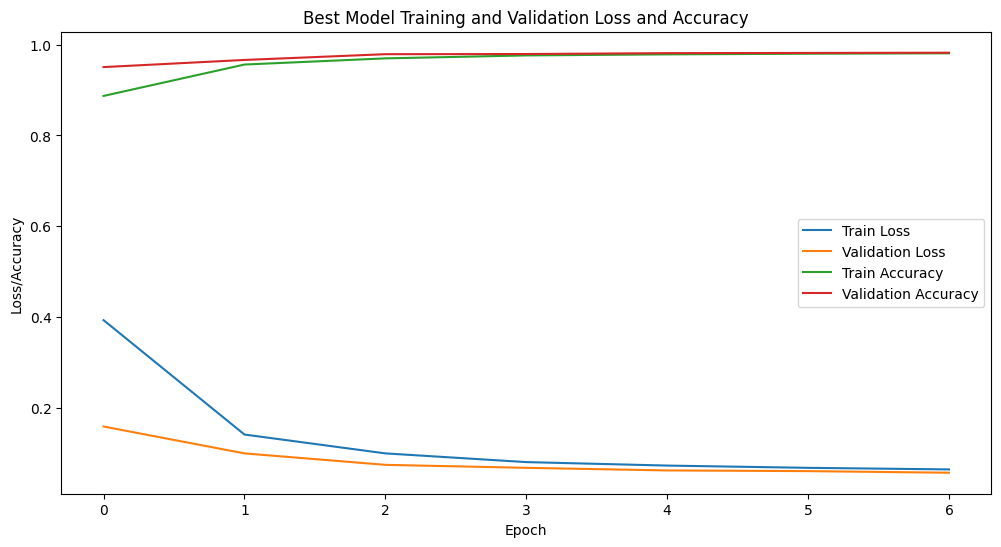

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step


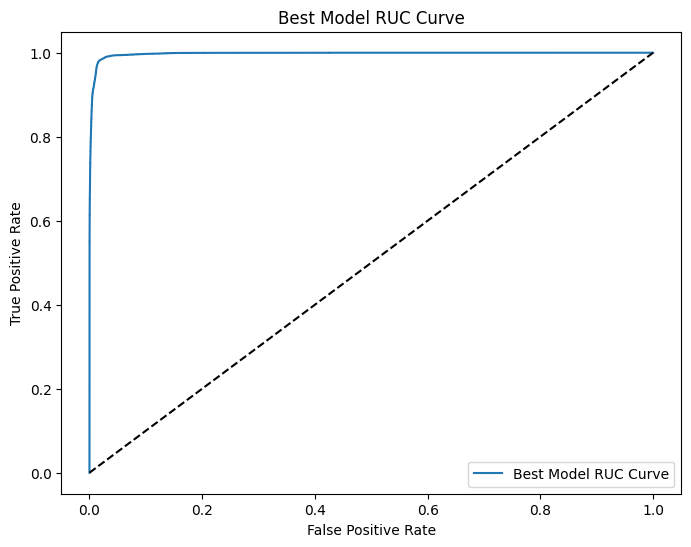

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step


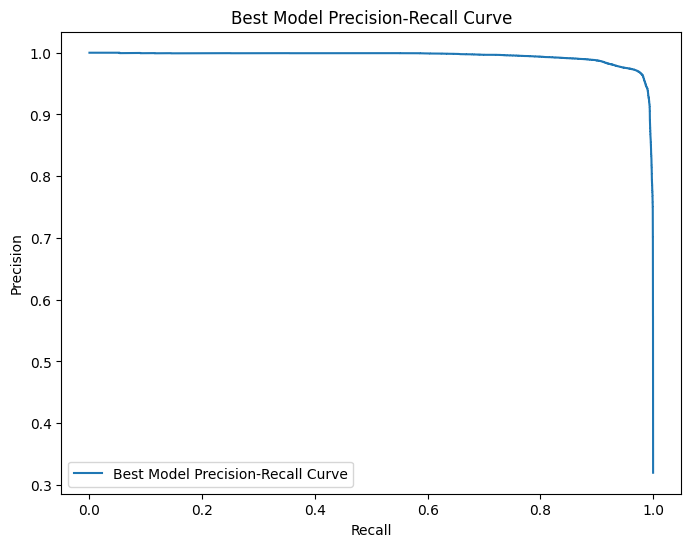

array([[[0.91886585, 0.40046274, 0.65228736, ..., 0.        ,
         0.        , 0.        ],
        [0.04399995, 0.60821363, 0.68707846, ..., 0.        ,
         0.        , 0.        ],
        [0.04118644, 0.39863106, 0.90377514, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.97406498, 0.3994987 , 0.88160344, ..., 0.        ,
         0.        , 0.        ],
        [0.83387003, 0.3995951 , 0.00122074, ..., 0.        ,
         0.        , 0.        ],
        [0.98355452, 0.3994987 , 0.96331675, ..., 0.        ,
         0.        , 0.        ]],

       [[0.84185711, 0.40055914, 0.77813044, ..., 0.        ,
         0.        , 0.        ],
        [0.91996675, 0.39969151, 0.75374615, ..., 0.        ,
         0.        , 0.        ],
        [0.92103788, 0.39969151, 0.77674184, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.86329961, 0.40007712, 0.71004364, ..., 0.        ,
         0.        , 0.        ],
        [0.0

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score, classification_report, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt

# train the model with best params
# best_model = opt.best_estimator_.model_
# [CV] END batch_size=64, epochs=7, model__dropout=0.27248704102600513, model__hidden_layer=31, model__learning_rate=0.0034211757958664125, model__lstm_units=70; total time=14.2min
best_model = Sequential([
    Bidirectional(LSTM(
        140, 
        return_sequences=True,  # Only final output
        recurrent_dropout=0.2,
        recurrent_activation='sigmoid',
        activation='tanh'
    ),
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])),
    LayerNormalization(),
    Dropout(0.27),
    Bidirectional(LSTM(70)),
    LayerNormalization(),
    Dropout(0.27),
    Dense(31, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])
best_model.summary()

optimizer = Adam(
    learning_rate=0.0001,  # Very low initial LR
    clipnorm=1.0,  # Gradient clipping to prevent exploding gradients
    weight_decay=1e-4
)

best_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Recall(name='recall'),
        Precision(name='precision')
    ]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
class_weight_dict = {0: 1.0, 1: 1.0}

history_best = best_model.fit(
    X_train_seq_final, y_train_seq_final,
    validation_data=(X_val_seq, y_val_seq),
    epochs=7,
    batch_size=64,
    shuffle=False,  # Important for time series
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

# evaluate the best model
results_best = best_model.evaluate(X_test_seq, y_test_seq, verbose=2)

print("Best Model Test Loss: {}".format(results_best[0]))
print("Best Model Test Accuracy: {}".format(results_best[1]))

# calculate and print classification report for best model
y_pred_best = (best_model.predict(X_test_seq) > 0.5).astype("int32").flatten()
print(classification_report(y_test_seq, y_pred_best))
#confusion matrix for best model
cm_best = confusion_matrix(y_test_seq, y_pred_best)
print(cm_best)
# fnr and fpr for best model
tn, fp, fn, tp = cm_best.ravel()
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)
print("Best Model False Negative Rate (FNR):", fnr)
print("Best Model False Positive Rate (FPR):", fpr)

#plot validation loss and accuracy for best model
plt.figure(figsize=(12, 6))
plt.plot(history_best.history['loss'], label='Train Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.plot(history_best.history['accuracy'], label='Train Accuracy')
plt.plot(history_best.history['val_accuracy'], label='Validation Accuracy')
plt.title('Best Model Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

# plot the fnr vs fpr tarde off curve for best model 
fpr, tpr, _ = roc_curve(y_test_seq, best_model.predict(X_test_seq).ravel())
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Best Model RUC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Best Model RUC Curve')
plt.legend()
plt.show()

# plot precision-recall curve for best model
precision, recall, _ = precision_recall_curve(y_test_seq, best_model.predict(X_test_seq).ravel())
plt.figure(figsize=(8, 6))  
plt.plot(recall, precision, label='Best Model Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Best Model Precision-Recall Curve') 
plt.legend()
plt.show()



2756/2756 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step
Threshold: 0.01 | F1: 0.8413 | FNR: 0.0005 | FPR: 0.1770
Threshold: 0.02 | F1: 0.8899 | FNR: 0.0023 | FPR: 0.1150
Threshold: 0.03 | F1: 0.9281 | FNR: 0.0049 | FPR: 0.0701
Threshold: 0.04 | F1: 0.9415 | FNR: 0.0057 | FPR: 0.0554
Threshold: 0.05 | F1: 0.9493 | FNR: 0.0060 | FPR: 0.0471
Threshold: 0.06 | F1: 0.9523 | FNR: 0.0061 | FPR: 0.0439
Threshold: 0.07 | F1: 0.9533 | FNR: 0.0063 | FPR: 0.0428
Threshold: 0.08 | F1: 0.9536 | FNR: 0.0067 | FPR: 0.0423
Threshold: 0.09 | F1: 0.9543 | FNR: 0.0067 | FPR: 0.0416
Threshold: 0.10 | F1: 0.9549 | FNR: 0.0069 | FPR: 0.0408
Threshold: 0.11 | F1: 0.9556 | FNR: 0.0070 | FPR: 0.0401
Threshold: 0.12 | F1: 0.9560 | FNR: 0.0070 | FPR: 0.0397
Threshold: 0.13 | F1: 0.9565 | FNR: 0.0071 | FPR: 0.0391
Threshold: 0.14 | F1: 0.9569 | FNR: 0.0072 | FPR: 0.0386
Threshold: 0.15 | F1: 0.9573 | FNR: 0.0074 | FPR: 0.0381
Threshold: 0.16 | F1: 0.9578 | FNR: 0.0075 | FPR: 0.0376
Threshold: 0.17 | F1: 0.9581 | FNR: 0.0076 

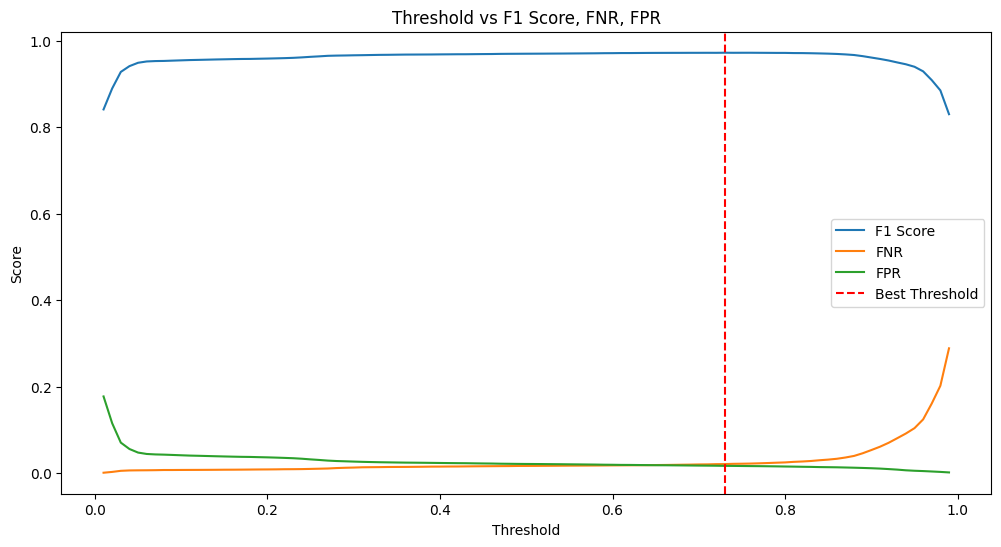

In [22]:
# Get predicted probabilities
y_pred_probs = best_model.predict(X_test_seq).ravel()

# Try thresholds from 0.01 to 0.99
thresholds = np.arange(0.01, 1.0, 0.01)
f1_scores = []
fnr_list = []
fpr_list = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_probs > thresh).astype("int32")
    f1 = f1_score(y_test_seq, y_pred_thresh)
    cm = confusion_matrix(y_test_seq, y_pred_thresh)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        print(f"Threshold: {thresh:.2f} | F1: {f1:.4f} | FNR: {fnr:.4f} | FPR: {fpr:.4f}")
    else:
        fnr = fpr = 0
    f1_scores.append(f1)
    fnr_list.append(fnr)
    fpr_list.append(fpr)

# Find the best threshold
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print(f"Best threshold: {best_thresh:.2f} with F1-score: {f1_scores[best_idx]:.4f}")
print(f"FNR: {fnr_list[best_idx]:.4f}, FPR: {fpr_list[best_idx]:.4f}")

# plot the threshold graph
plt.figure(figsize=(12, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, fnr_list, label='FNR')
plt.plot(thresholds, fpr_list, label='FPR')
plt.axvline(x=best_thresh, color='r', linestyle='--', label='Best Threshold')
plt.title('Threshold vs F1 Score, FNR, FPR')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()


In [23]:

# Use the best threshold for final predictions
best_thresh = 0.25
y_pred_best_thresh = (y_pred_probs > best_thresh).astype("int32")
print(classification_report(y_test_seq, y_pred_best_thresh))
cm_best = confusion_matrix(y_test_seq, y_pred_best_thresh)
print(cm_best)
if cm_best.shape == (2, 2):
    tn, fp, fn, tp = cm_best.ravel()
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)
    print("Best Model False Negative Rate (FNR):", fnr)
    print("Best Model False Positive Rate (FPR):", fpr)
else:
    print("Confusion matrix shape is not 2x2.")

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     59990
           1       0.94      0.99      0.96     28200

    accuracy                           0.98     88190
   macro avg       0.97      0.98      0.97     88190
weighted avg       0.98      0.98      0.98     88190

[[58111  1879]
 [  262 27938]]
Best Model False Negative Rate (FNR): 0.00929078014184397
Best Model False Positive Rate (FPR): 0.031321886981163526
